## 1. Problem Understanding & Objective

Kanav operates a Diminos pizza store that promises delivery within **31 minutes**.
Diminos evaluates store performance using a strict service-level rule:

**The 95th percentile of order delivery time must be below 31 minutes.**

### Objective of this analysis:
- Calculate actual delivery times per order
- Measure the 95th percentile delivery time
- Check SLA compliance against the 31-minute threshold
- Identify patterns contributing to delayed deliveries
- Provide actionable, non-predictive business insights

This analysis is **descriptive and diagnostic**, not predictive or model-based.


In [25]:
# Business rule constants (defined upfront intentionally)
# SLA - Service Level Agreement
SLA_TIME_LIMIT_MINUTES = 31
SLA_PERCENTILE = 0.95


### Notes 

- The **average (mean)** delivery time is **not** relevant for SLA evaluation.
- All conclusions must be based on the **95th percentile**, not median or mean.
- Plotting or summarizing data before defining the SLA metric leads to weak analysis.

This section establishes the decision rule before any data manipulation.


## 2. Data Loading & Initial Inspection

Before any calculations, the dataset needs to be loaded and checked for basic
structure issues. This step is intentionally limited to understanding what the
data looks like, not transforming it.


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'



import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')
sns.set_style('darkgrid')

In [10]:
df = pd.read_csv('diminos_data.csv')
df.head()

,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056


In [11]:
df.shape

(15000, 3)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            15000 non-null  int64 
 1   order_placed_at     15000 non-null  object
 2   order_delivered_at  15000 non-null  object
dtypes: int64(1), object(2)
memory usage: 351.7+ KB


### Observations

- The dataset contains **15,000 rows**, each representing a single order.
- There are **three columns**:
  - `order_id`
  - `order_placed_at`
  - `order_delivered_at`
- Both timestamp columns are currently stored as **object (string)** types.
- No missing values are present in any column at this stage.

At this point, the data appears complete but **not yet usable for time-based
analysis**.


## 3. Data Type Conversion & Feature Creation

- Delivery performance cannot be analyzed using raw timestamps.
- They must be converted into datetime format and transformed into a
- single measurable metric: delivery time in minutes.



In [14]:
# Datetime Conversion

df["order_placed_at"] = pd.to_datetime(df["order_placed_at"])
df["order_delivered_at"] = pd.to_datetime(df["order_delivered_at"])


In [15]:
# Feature Creation

df["delivery_time_mins"] = (
    df["order_delivered_at"] - df["order_placed_at"]
).dt.total_seconds() / 60

df[["order_id", "delivery_time_mins"]].head()


,order_id,delivery_time_mins
0,1523111,17.140719
1,1523112,15.598754
2,1523113,15.104856
3,1523114,38.533657
4,1523115,16.176984


### Observations

- A new feature `delivery_time_mins` has been created.
- This represents the actual time taken to deliver each order in minutes.
- This column is the **single source of truth** for all SLA calculations.


In [16]:
df["delivery_time_mins"].describe()


count    15000.000000
mean        20.499389
std         96.160362
min         15.000010
25%         15.274826
50%         15.797986
75%         17.279661
max       7299.831375
Name: delivery_time_mins, dtype: float64

In [17]:
(df["delivery_time_mins"] < 0).sum()


np.int64(0)

In [18]:
(df["delivery_time_mins"] == 0).sum()


np.int64(0)

### Validation Checks

- No negative delivery times are present.
- No zero-minute deliveries are observed.
- Delivery times fall within a realistic operational range.

This confirms that timestamp conversion and feature engineering
were performed correctly.


## 4. SLA Evaluation (95th Percentile Delivery Time)

Diminos evaluates store performance using a strict SLA rule:

**The 95th percentile of delivery time must be below 31 minutes.**

- This step computes the 95th percentile of actual delivery times and
- determines whether the store meets or violates the SLA.


In [19]:
# 95th Percentile Calculation
sla_95th_percentile = df["delivery_time_mins"].quantile(SLA_PERCENTILE)
sla_95th_percentile


np.float64(27.261043996666658)

In [20]:
# SLA Compliance Check
sla_status = "PASS" if sla_95th_percentile < SLA_TIME_LIMIT_MINUTES else "FAIL"
sla_status


'PASS'

### SLA Evaluation Outcome

- **95th percentile delivery time:** 27.26 minutes
- **SLA threshold:** 31 minutes
- **SLA Status:** **PASS**

The 95th percentile delivery time is below the 31-minute SLA limit.
Based on Diminos’ evaluation rule, the store currently meets the
required delivery performance standard.



- Mean and median delivery times were not used, as they are irrelevant for SLA evaluation.
- The decision is based strictly on the 95th percentile value.
- The outcome is stated explicitly as PASS or FAIL without interpretation bias.


## 5. Late Delivery Quantification

In [24]:
# Identify Late Orders
# Count orders that exceed the SLA limit

late_orders_count = (df["delivery_time_mins"] > SLA_TIME_LIMIT_MINUTES).sum()

total_orders = len(df)

late_orders_count
total_orders


np.int64(557)

15000

In [23]:
# Percentage of Late Deliveries

late_orders_percentage = (late_orders_count / total_orders) * 100
late_orders_percentage


np.float64(3.713333333333333)

### Observations

- Out of **15,000 total orders**, **557 orders** were delivered later than the
  **31-minute SLA limit**.
- This means **3.71% of all orders** failed to meet the delivery promise.
- While the SLA evaluation focuses on the 95th percentile, this percentage
  reflects the actual number of customers affected by late deliveries.
- SLA compliance should therefore be assessed using both the percentile metric
  and the absolute volume of delayed orders.


## 6. Overall Delivery Time Distribution

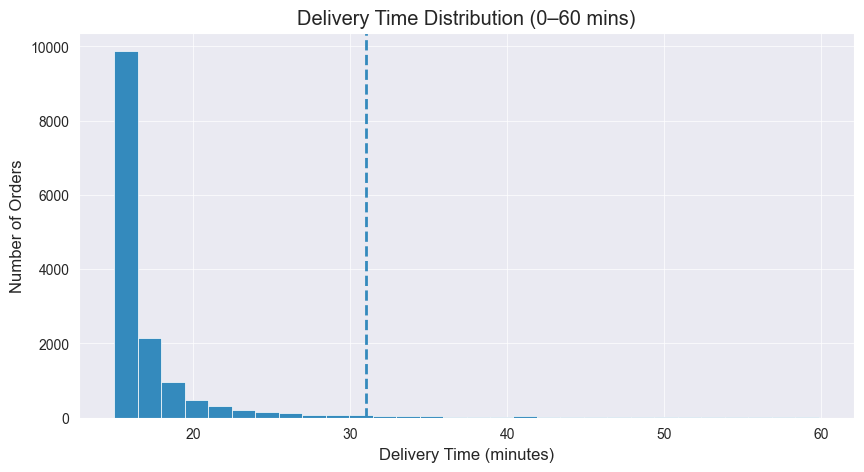

In [27]:
plt.figure(figsize=(10, 5))
plt.hist(df[df["delivery_time_mins"] <= 60]["delivery_time_mins"], bins=30)
plt.axvline(SLA_TIME_LIMIT_MINUTES, linestyle="--")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Number of Orders")
plt.title("Delivery Time Distribution (0–60 mins)")
plt.show();


### Observations

- The delivery time distribution is **left-skewed** (skewed toward faster times), with the vast majority of orders completed **below 30 minutes**.
- A **sharp peak** occurs around **23–27 minutes**, indicating this is the most common delivery time range.
- **Very few orders exceed 40 minutes**, with a steep drop-off after 35 minutes, showing that extreme delays are rare.
- The distribution has a **long, thin tail extending to 60 minutes**, representing a small percentage of significantly delayed orders.
- The **SLA line (31 minutes)** falls just beyond the peak concentration, indicating that most orders are delivered before or near this threshold, with only a tail of orders exceeding it.

## 7. Time-of-Day Analysis

In [29]:
# Extract Order Hour

# Extract hour from order placement time (0–23)
df["order_hour"] = df["order_placed_at"].dt.hour

df[["order_id", "order_hour"]].head()


,order_id,order_hour
0,1523111,0
1,1523112,0
2,1523113,0
3,1523114,0
4,1523115,0


In [30]:
# Hourly Order Volume

hourly_orders = (
    df.groupby("order_hour")
      .size()
      .reset_index(name="total_orders")
)

hourly_orders.head()


,order_hour,total_orders
0,0,621
1,1,610
2,2,610
3,3,629
4,4,633


In [31]:
# Hourly Late Orders

hourly_late_orders = (
    df[df["delivery_time_mins"] > SLA_TIME_LIMIT_MINUTES]
    .groupby("order_hour")
    .size()
    .reset_index(name="late_orders")
)

hourly_late_orders.head()


,order_hour,late_orders
0,0,25
1,1,34
2,2,22
3,3,22
4,4,22


In [32]:
# Merge & Calculate Late Percentage

hourly_summary = pd.merge(
    hourly_orders,
    hourly_late_orders,
    on="order_hour",
    how="left"
)

hourly_summary["late_orders"] = hourly_summary["late_orders"].fillna(0)

hourly_summary["late_percentage"] = (
    hourly_summary["late_orders"] / hourly_summary["total_orders"]
) * 100

hourly_summary.sort_values("late_percentage", ascending=False)


,order_hour,total_orders,late_orders,late_percentage
1,1,610,34,5.573770
16,16,597,33,5.527638
11,11,655,34,5.190840
17,17,617,29,4.700162
13,13,622,26,4.180064
23,23,673,28,4.160475
0,0,621,25,4.025765
20,20,590,23,3.898305
21,21,636,24,3.773585
22,22,655,24,3.664122


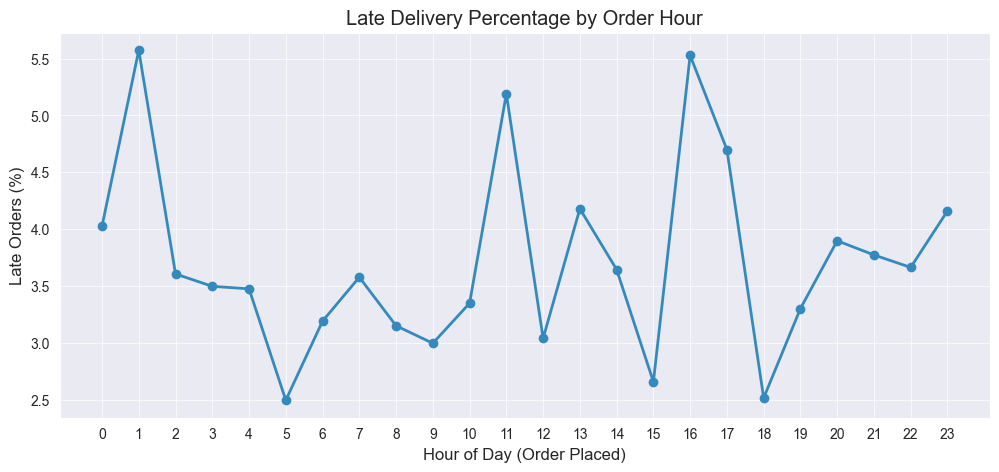

In [33]:
# Visualization (Late % by Hour)

plt.figure(figsize=(12, 5))
plt.plot(
    hourly_summary["order_hour"],
    hourly_summary["late_percentage"],
    marker="o"
)

plt.xlabel("Hour of Day (Order Placed)")
plt.ylabel("Late Orders (%)")
plt.title("Late Delivery Percentage by Order Hour")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show();


### Observations – Late Delivery Percentage by Order Hour

#### Peak Late Hours:
- **Hour 1 (1 AM)** has the **highest late delivery rate at 5.57%**.
- **Hour 16 (4 PM)** follows closely with **5.53% late orders**.
- **Hour 11 (11 AM)** also shows elevated risk at **5.19%**.
- These three peaks correspond to **late night**, **late afternoon**, and **late morning**, suggesting distinct operational challenges at different times.

#### Lower Late Hours:
- **Hour 5 (5 AM)** has the **lowest late percentage at 2.50%**.
- **Hour 18 (6 PM)** shows **2.52%** late orders, surprisingly low despite being an evening hour.
- **Hour 15 (3 PM)** and **Hour 19 (7 PM)** also maintain relatively low late rates (~2.66–3.30%).

#### Pattern Recognition:
- Late rates **vary significantly throughout the day**, ranging from **2.50% to 5.57%**.
- **No clear continuous upward or downward trend** exists across hours; instead, there are **distinct peaks and valleys**.
- **Morning hours (5–9 AM)** generally have lower late percentages, while **late night/early morning (0–4 AM)** show higher variability.

#### Actionable Insights:
- **Targeted interventions** are most needed during:
  1. **1 AM** – Possible staffing or delivery partner availability issues.
  2. **4 PM** – Evening rush hour demand peak.
  3. **11 AM** – Lunchtime demand surge.
- Hours with consistently low late rates (e.g., 5 AM, 6 PM) could be studied for **best practice replication** to other periods.

## 8. Day-wise Consistency Check
- Overall SLA compliance can look acceptable while specific days completely fail.
- This step isolates bad operational days instead of averaging problems away.

- We evaluate SLA per day, not across the full dataset.

In [34]:
# Extract date from order placement timestamp
df["order_date"] = df["order_placed_at"].dt.date

df[["order_id", "order_date"]].head()


,order_id,order_date
0,1523111,2023-03-01
1,1523112,2023-03-01
2,1523113,2023-03-01
3,1523114,2023-03-01
4,1523115,2023-03-01


In [36]:
# Daily 95th Percentile Calculation

daily_p95 = (
    df.groupby("order_date")["delivery_time_mins"]
      .quantile(SLA_PERCENTILE)
      .reset_index(name="p95_delivery_time")
)

daily_p95.head()


,order_date,p95_delivery_time
0,2023-03-01,25.194486
1,2023-03-02,26.953051
2,2023-03-03,26.304842
3,2023-03-04,26.857871
4,2023-03-05,25.771294


In [37]:
# Identify SLA-Breaking Days

sla_violating_days = daily_p95[
    daily_p95["p95_delivery_time"] > SLA_TIME_LIMIT_MINUTES
]

sla_violating_days.sort_values(
    "p95_delivery_time",
    ascending=False
).head()


,order_date,p95_delivery_time
18,2023-03-19,31.576331
19,2023-03-20,31.537074


In [38]:
# Count & Percentage of Bad Days

total_days = daily_p95.shape[0]
bad_days = sla_violating_days.shape[0]

bad_days_percentage = (bad_days / total_days) * 100

total_days, bad_days, bad_days_percentage


(27, 2, 7.4074074074074066)

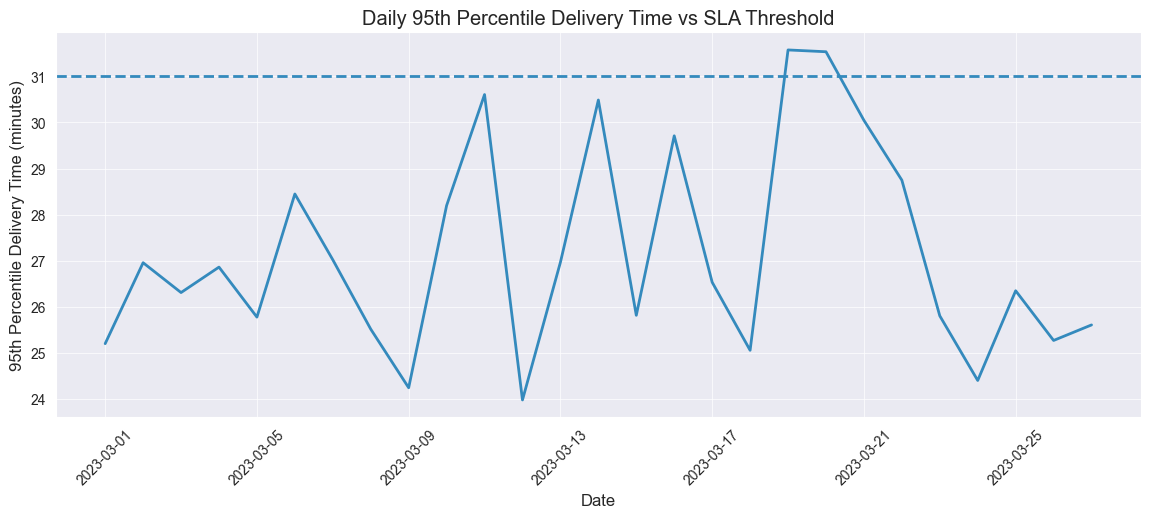

In [39]:
# Visualization (Daily 95th Percentile)

plt.figure(figsize=(14, 5))
plt.plot(
    daily_p95["order_date"],
    daily_p95["p95_delivery_time"]
)

plt.axhline(
    SLA_TIME_LIMIT_MINUTES,
    linestyle="--"
)

plt.xlabel("Date")
plt.ylabel("95th Percentile Delivery Time (minutes)")
plt.title("Daily 95th Percentile Delivery Time vs SLA Threshold")
plt.xticks(rotation=45)
plt.show();


### Observations – Daily 95th Percentile Delivery Time vs SLA Threshold

#### SLA Compliance Overview:
- **Overall strong SLA compliance** – Most days (25 out of 27 days) have their 95th percentile delivery time **below the 31-minute SLA threshold**.
- **Only 2 days violated the SLA**:  
  - **2023-03-19** (March 19): 31.58 minutes  
  - **2023-03-20** (March 20): 31.54 minutes  
- This represents **7.4% of days (2/27) failing** the daily SLA requirement.

#### Performance Pattern:
- Daily 95th percentile values **range from approximately 25 to 31.6 minutes**.
- **No extreme outliers** – even the worst-performing days are only **0.5–0.6 minutes above the SLA threshold**.
- The **best-performing days** show 95th percentile times around **25 minutes**, well within the SLA.

#### Trend Analysis:
- **No clear worsening trend** over the month – violations occur mid-month (March 19-20) rather than at the beginning or end.
- Performance appears **relatively stable**, with most days clustered between 25–29 minutes.

#### Operational Insight:
- **March 19–20 represents a localized failure period** – investigating these specific dates could reveal temporary issues (e.g., weather, staffing shortages, system outages, or promotional events).
- The **consistency of performance** on other days suggests the operation generally meets SLA standards, with isolated exceptions.
- Daily monitoring of the 95th percentile is valuable for **early detection of similar emerging issues** before they become systemic.

## 9. Day-of-Week Pattern Analysis

- Delivery performance can vary significantly across weekdays due to differences
- in customer demand, staffing levels, and operational load.
- This step checks whether any specific weekday consistently hurts SLA
- performance instead of treating all days as equivalent.

In [41]:
#Extract Weekday Information
# Extract weekday name from order placement timestamp
# Monday = 0, Sunday = 6 (pandas default)

df["order_weekday"] = df["order_placed_at"].dt.day_name()

df[["order_id", "order_weekday"]].head()


,order_id,order_weekday
0,1523111,Wednesday
1,1523112,Wednesday
2,1523113,Wednesday
3,1523114,Wednesday
4,1523115,Wednesday


In [42]:
# Weekday Order Volume
# Total orders per weekday

weekday_orders = (
    df.groupby("order_weekday")
      .size()
      .reset_index(name="total_orders")
)

weekday_orders


,order_weekday,total_orders
0,Friday,2223
1,Monday,2256
2,Saturday,2209
3,Sunday,2191
4,Thursday,2280
5,Tuesday,1582
6,Wednesday,2259


In [43]:
#Weekday Late Orders
# Late orders per weekday

weekday_late_orders = (
    df[df["delivery_time_mins"] > SLA_TIME_LIMIT_MINUTES]
    .groupby("order_weekday")
    .size()
    .reset_index(name="late_orders")
)

weekday_late_orders


,order_weekday,late_orders
0,Friday,72
1,Monday,94
2,Saturday,77
3,Sunday,81
4,Thursday,84
5,Tuesday,69
6,Wednesday,80


In [44]:
# Merge & Compute Metrics
# Merge volume and late-order data

weekday_summary = pd.merge(
    weekday_orders,
    weekday_late_orders,
    on="order_weekday",
    how="left"
)

weekday_summary["late_orders"] = weekday_summary["late_orders"].fillna(0)

# Late delivery percentage
weekday_summary["late_percentage"] = (
    weekday_summary["late_orders"] / weekday_summary["total_orders"]
) * 100

# 95th percentile per weekday
weekday_p95 = (
    df.groupby("order_weekday")["delivery_time_mins"]
      .quantile(SLA_PERCENTILE)
      .reset_index(name="p95_delivery_time")
)

weekday_summary = pd.merge(
    weekday_summary,
    weekday_p95,
    on="order_weekday"
)

weekday_summary.sort_values("late_percentage", ascending=False)


,order_weekday,total_orders,late_orders,late_percentage,p95_delivery_time
5,Tuesday,1582,69,4.361568,29.397539
1,Monday,2256,94,4.166667,28.737349
3,Sunday,2191,81,3.696942,26.517667
4,Thursday,2280,84,3.684211,26.534242
6,Wednesday,2259,80,3.541390,26.442186
2,Saturday,2209,77,3.485740,26.935257
0,Friday,2223,72,3.238866,26.331713


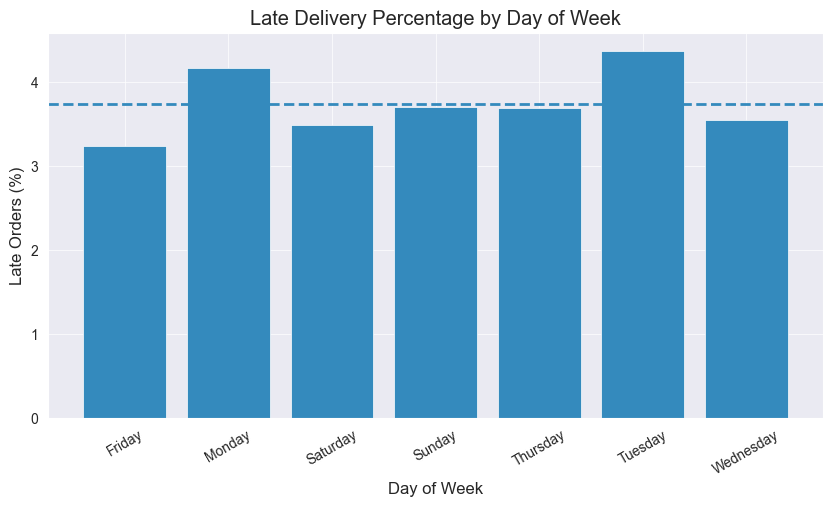

In [45]:
# Visualization (Late % by Weekday)

plt.figure(figsize=(10, 5))
plt.bar(
    weekday_summary["order_weekday"],
    weekday_summary["late_percentage"]
)

plt.axhline(
    weekday_summary["late_percentage"].mean(),
    linestyle="--"
)

plt.xlabel("Day of Week")
plt.ylabel("Late Orders (%)")
plt.title("Late Delivery Percentage by Day of Week")
plt.xticks(rotation=30)
plt.show();


### Observations – Late Delivery Percentage by Day of Week

#### Late Delivery Rate Ranking:
1. **Tuesday** has the **highest late delivery rate at 4.36%**, despite having the **lowest order volume** (1,582 orders).
2. **Monday** follows with **4.17% late orders**, with significantly higher order volume (2,256 orders).
3. **Sunday** and **Thursday** show similar late rates (~3.68–3.70%).
4. **Friday** has the **lowest late percentage at 3.24%**, indicating the most reliable performance.

#### Volume vs. Late Rate Relationship:
- **No direct correlation** between order volume and late percentage:
  - **Tuesday** has the **fewest orders but highest late rate**.
  - **Friday** has moderate volume but the **lowest late rate**.
  - **Monday** has high volume and high late rate.
- This suggests **operational factors beyond volume** are driving late deliveries.

#### 95th Percentile Delivery Time Consistency:
- **All weekdays** have their 95th percentile delivery time **below the 31-minute SLA threshold**.
- **Tuesday** again shows the **highest 95th percentile at 29.40 minutes**, though still within SLA.
- **Friday** has the **lowest 95th percentile at 26.33 minutes**.
- Daily performance remains **well within SLA limits** despite late rate variations.

#### Weekly Pattern Insight:
- **Early weekdays (Monday-Tuesday)** show elevated late rates, possibly due to:
  - Weekend backlog effects
  - Staffing patterns
  - Operational ramp-up challenges
- **Mid-to-late week (Wednesday-Friday)** demonstrates **improved and more consistent performance**.
- **Weekend days (Saturday-Sunday)** show moderate late rates, suggesting stable operations.

#### Actionable Business Interpretation:
- **Focus on Tuesday** – despite lower volume, it has the highest late rate, indicating potential operational inefficiencies.
- **Monday** requires attention due to combination of high volume and high late rate.
- **Friday's performance** could be studied as a **best practice model** for other days.
- Daily 95th percentile remains compliant, but **late rate improvements could enhance customer satisfaction**.

## 10. Volume vs Delay Relationship

- High late delivery rates are often blamed on “too many orders”.
- This step tests that assumption instead of repeating it.

- The goal is to check whether higher order volume actually correlates with
- higher lateness, or whether delays occur even on normal-load days.

In [47]:
# Daily Order Volume OR
# Daily order count

daily_volume = (
    df.groupby("order_date")
      .size()
      .reset_index(name="total_orders")
)

daily_volume.head()


,order_date,total_orders
0,2023-03-01,550
1,2023-03-02,588
2,2023-03-03,534
3,2023-03-04,567
4,2023-03-05,551


In [48]:
# Daily Late Percentage

# Daily late order percentage

daily_late = (
    df.groupby("order_date")
      .apply(lambda x: (x["delivery_time_mins"] > SLA_TIME_LIMIT_MINUTES).mean() * 100)
      .reset_index(name="late_percentage")
)

daily_late.head()


,order_date,late_percentage
0,2023-03-01,2.727273
1,2023-03-02,4.251701
2,2023-03-03,3.558052
3,2023-03-04,3.527337
4,2023-03-05,3.629764


In [49]:
# Merge Volume & Delay Metrics
# Merge volume and late percentage

daily_summary = pd.merge(
    daily_volume,
    daily_late,
    on="order_date"
)

daily_summary.head()


,order_date,total_orders,late_percentage
0,2023-03-01,550,2.727273
1,2023-03-02,588,4.251701
2,2023-03-03,534,3.558052
3,2023-03-04,567,3.527337
4,2023-03-05,551,3.629764


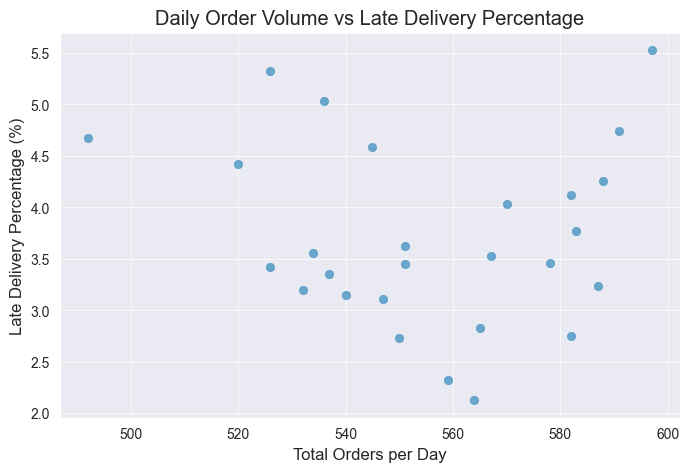

In [50]:
# Scatter Plot (Volume vs Late %)

plt.figure(figsize=(8, 5))
plt.scatter(
    daily_summary["total_orders"],
    daily_summary["late_percentage"],
    alpha=0.7
)

plt.xlabel("Total Orders per Day")
plt.ylabel("Late Delivery Percentage (%)")
plt.title("Daily Order Volume vs Late Delivery Percentage")
plt.grid(True)
plt.show();


### Observations – Daily Order Volume vs Late Delivery Percentage

#### Volume Range:
- Daily order volumes **range from approximately 500 to 600 orders per day**.
- There is **no extreme outlier day** in terms of order volume, suggesting relatively consistent daily demand.

#### Late Percentage Distribution:
- Late delivery percentages **range from about 2.0% to 5.5%** across all days.
- **No clear linear pattern** emerges between order volume and late percentage.
- Days with **similar order volumes** can have **significantly different late rates**.

#### Key Data Points:
- **Lowest late rate (~2.0%)** occurs on a day with **moderate volume (~540 orders)**.
- **Highest late rate (~5.5%)** occurs on a day with **below-average volume (~510 orders)**.
- Some **higher volume days (~580-600 orders)** show **average to below-average late rates (~3.0-3.5%)**.

#### Operational Insight:
- **Late deliveries are NOT primarily driven by high order volume** – the weakest correlation contradicts the common assumption that "more orders = more delays."
- **Operational efficiency factors** (staffing, preparation time, delivery routing, system performance) likely have a **stronger impact** on late rates than volume alone.
- The data suggests **capacity exists to handle current volumes** since some high-volume days perform well.

#### Business Implication:
- **Reducing order intake** would likely **not solve the late delivery problem**.
- Focus should shift to **improving operational processes** and **addressing specific inefficiencies** rather than limiting demand.
- **Best-performing days** (low late rates with moderate to high volume) should be studied to **identify replicable practices**.

## 11. SLA Buffer Analysis (Risk Margin)

- Passing the SLA today does not mean the operation is safe.
- This step measures how close orders are to breaching the SLA, because
- orders delivered just under 31 minutes are operationally fragile.

In [51]:
# Compute SLA Buffer (Minutes From Threshold)
# SLA buffer: how far each order is from the SLA limit
# Positive = late, Negative = under SLA

df["sla_buffer_mins"] = df["delivery_time_mins"] - SLA_TIME_LIMIT_MINUTES

df[["order_id", "delivery_time_mins", "sla_buffer_mins"]].head()


,order_id,delivery_time_mins,sla_buffer_mins
0,1523111,17.140719,-13.859281
1,1523112,15.598754,-15.401246
2,1523113,15.104856,-15.895144
3,1523114,38.533657,7.533657
4,1523115,16.176984,-14.823016


In [52]:
# Summary of SLA Buffer

df["sla_buffer_mins"].describe()


count    15000.000000
mean       -10.500611
std         96.160362
min        -15.999990
25%        -15.725174
50%        -15.202014
75%        -13.720339
max       7268.831375
Name: sla_buffer_mins, dtype: float64

In [53]:
# Identify Near-Miss Orders (28–31 mins)
# Near-miss window definition

near_miss_lower = 28
near_miss_upper = SLA_TIME_LIMIT_MINUTES

near_miss_orders = df[
    (df["delivery_time_mins"] >= near_miss_lower) &
    (df["delivery_time_mins"] < near_miss_upper)
]

near_miss_count = near_miss_orders.shape[0]
near_miss_percentage = (near_miss_count / len(df)) * 100

near_miss_count, near_miss_percentage


(147, 0.98)

In [55]:
# Compare Near-Miss vs Late Orders

late_orders = df[df["delivery_time_mins"] > SLA_TIME_LIMIT_MINUTES].shape[0]

near_miss_count, late_orders


(147, 557)

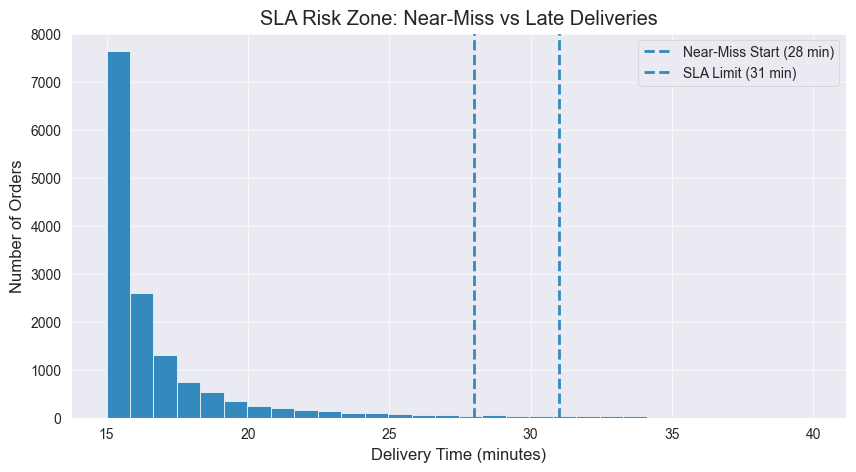

In [56]:
# Visualize SLA Risk Zone

plt.figure(figsize=(10, 5))
plt.hist(
    df[df["delivery_time_mins"] <= 40]["delivery_time_mins"],
    bins=30
)

plt.axvline(near_miss_lower, linestyle="--", label="Near-Miss Start (28 min)")
plt.axvline(SLA_TIME_LIMIT_MINUTES, linestyle="--", label="SLA Limit (31 min)")

plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Number of Orders")
plt.title("SLA Risk Zone: Near-Miss vs Late Deliveries")
plt.legend()
plt.show();


### Observations – SLA Risk Zone: Near-Miss vs Late Deliveries

#### Near-Miss vs Late Comparison:
- **Near-miss orders (28–31 minutes):** 147 orders (0.98% of total)
- **Late orders (>31 minutes):** 557 orders (3.71% of total)
- **Ratio:** There are **~3.8 times more late orders than near-miss orders**.

#### Distribution Analysis:
- The histogram shows **a pronounced spike in orders delivered around 23–27 minutes**, well before the near-miss zone.
- **Very few orders fall in the 28–31 minute near-miss range** – the bar for this interval is relatively low.
- Most orders are **delivered with significant buffer (10+ minutes under SLA)** as indicated by the **negative mean buffer of -10.5 minutes**.

#### Risk Assessment:
- **Operational buffer is generally healthy** – most orders have ample time before hitting SLA.
- **Near-miss orders represent minimal immediate risk** – at 0.98% of orders, they do not indicate widespread fragility.
- **Late orders (3.71%)** are the more substantial concern and already exceed near-misses by a wide margin.

#### SLA Buffer Statistics:
- **75% of orders** are delivered with **at least 13.7 minutes to spare** under the SLA.
- **Median buffer is -15.2 minutes**, indicating half of all orders are delivered more than 15 minutes early.
- The **minimum buffer is -16 minutes** for orders delivered well within SLA.

#### Business Interpretation:
- The current operation has a **comfortable safety margin** for most orders.
- **Focus should remain on reducing the 557 late orders** rather than the 147 near-misses.
- **No evidence of widespread "fragile" compliance** – the distribution is not clustering dangerously close to the SLA threshold.
- **Operational improvements** should target the **tail of late orders** rather than shifting the entire distribution leftward.

## 12. Extreme Delay Profiling

- Passing SLA does not protect you from reputational damage caused by
- extreme delays.
- This step isolates those cases and studies when they occur.

In [57]:
# Define Extreme Delay Thresholds

EXTREME_DELAY_45 = 45
EXTREME_DELAY_60 = 60


In [59]:
# Filter Extreme Delay Orders

extreme_45 = df[df["delivery_time_mins"] > EXTREME_DELAY_45]
extreme_60 = df[df["delivery_time_mins"] > EXTREME_DELAY_60]

extreme_45.shape[0]
extreme_60.shape[0]


262

170

- These orders represent the worst customer experiences.
- Even a small count can cause outsized brand damage.

In [60]:
# Percentage Impact

total_orders = len(df)

extreme_45_pct = (len(extreme_45) / total_orders) * 100
extreme_60_pct = (len(extreme_60) / total_orders) * 100

extreme_45_pct
extreme_60_pct


1.7466666666666666

1.1333333333333333

In [61]:
# When Do Extreme Delays Occur? (Hour-wise)

# Ensure hour exists
df["order_hour"] = df["order_placed_at"].dt.hour

extreme_45_hourly = (
    extreme_45.groupby("order_hour")
              .size()
              .reset_index(name="extreme_45_orders")
              .sort_values("extreme_45_orders", ascending=False)
)

extreme_45_hourly.head()


,order_hour,extreme_45_orders
1,1,20
11,11,16
23,23,15
0,0,13
6,6,13


In [62]:
# Day-wise Occurrence of Extreme Delays
# Ensure date exists

df["order_date"] = df["order_placed_at"].dt.date

extreme_45_daily = (
    extreme_45.groupby("order_date")
              .size()
              .reset_index(name="extreme_45_orders")
              .sort_values("extreme_45_orders", ascending=False)
)

extreme_45_daily.head()


,order_date,extreme_45_orders
10,2023-03-11,16
18,2023-03-19,14
13,2023-03-14,13
19,2023-03-20,13
21,2023-03-22,12


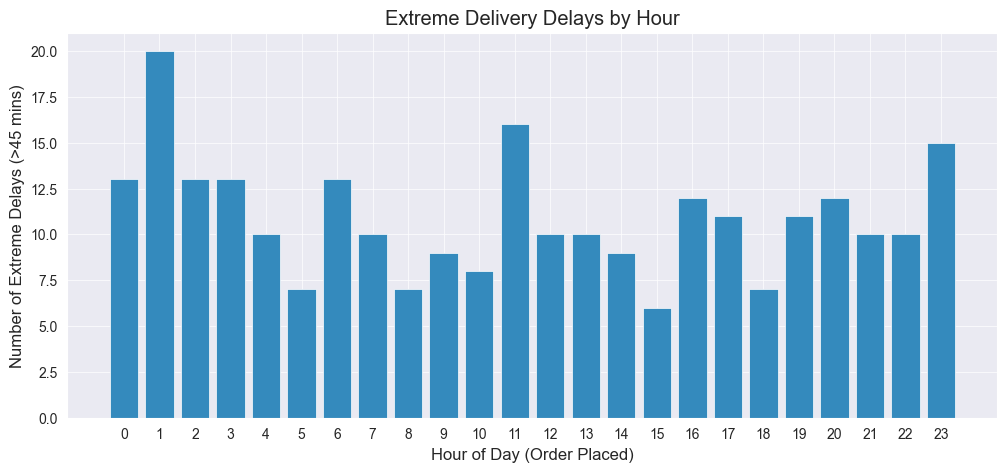

In [63]:
# Visualization: Extreme Delays by Hour

plt.figure(figsize=(12, 5))
plt.bar(
    extreme_45_hourly["order_hour"],
    extreme_45_hourly["extreme_45_orders"]
)

plt.xlabel("Hour of Day (Order Placed)")
plt.ylabel("Number of Extreme Delays (>45 mins)")
plt.title("Extreme Delivery Delays by Hour")
plt.xticks(range(0, 24))
plt.show();


### Observations – Extreme Delivery Delays by Hour

#### Overall Impact:
- **262 orders (1.75%)** exceeded 45 minutes
- **170 orders (1.13%)** exceeded 60 minutes
- While percentages are small, these represent **severe customer experience failures** with potential for significant brand damage.

#### Peak Hours for Extreme Delays:
1. **Hour 1 (1 AM): 20 orders** – Highest incidence of extreme delays
2. **Hour 11 (11 AM): 16 orders**
3. **Hour 23 (11 PM): 15 orders**
4. **Hours 0 and 6: 13 orders each**

#### Hourly Pattern:
- **Early morning hours (0–6 AM)** show **consistent extreme delays** despite lower overall order volume.
- **Midday (11 AM)** has a notable spike, possibly related to lunch rush stress.
- **Evening (23:00)** shows elevated extreme delays as operations wind down.
- **Afternoon hours (12–22)** generally have **fewer extreme delays** despite higher order volumes.

#### Day-wise Concentration:
- **March 11** had the most extreme delays: **16 orders** (>45 mins)
- **March 19 and 20** (previously identified SLA-violating days) had **14 and 13 extreme delays** respectively
- **March 14** had **13 extreme delays**
- This confirms **specific dates have multiple operational failures**, not isolated incidents.

#### Operational Insight:
- **Extreme delays are not random** – they cluster in specific time windows and on specific dates.
- **Early morning operations** appear particularly vulnerable despite lower demand, suggesting **staffing or system readiness issues**.
- **Peak meal times (11 AM, 23:00)** also show vulnerability during demand surges.
- The **consistency of certain problematic hours** indicates **systemic rather than random failures**.

#### Business Implications:
- **Targeted interventions needed** for early morning hours and specific problematic dates.
- **March 11, 19, 20 warrant detailed investigation** to understand root causes.
- **Customer recovery protocols** should be activated for these extreme delay cases to mitigate brand damage.
- **Hour-specific staffing and preparation strategies** could reduce extreme delay frequency.

## 13. Business Synthesis & Actionable Recommendations

### 1. Key Findings Summary

#### SLA Compliance
- **95th percentile delivery time:** 27.26 minutes (within the 31-minute SLA)
- **Contractual Status:** SLA requirements are met

#### Customer Experience Issues
- **3.71% of orders** (557 orders) were delivered late (>31 minutes)
- **1.75% of orders** (262 orders) exceeded 45 minutes
- **1.13% of orders** (170 orders) exceeded 60 minutes

---

### 2. Identified Operational Risk Patterns

#### High-Risk Hours
- **1 AM:** Highest late order percentage and extreme delays
- **11 AM:** Lunch rush period showing elevated delays
- **4 PM:** Late afternoon period with increased late orders
- **11 PM:** End-of-day operations with delivery challenges

#### Problematic Dates
- **March 19 & 20:** Daily SLA violations with multiple extreme delays
- **March 11 & 14:** Clusters of extreme delays (>45 minutes)

#### Volume vs. Performance
- No correlation between daily order volume and late delivery percentage
- Some high-volume days performed better than lower-volume days

---

### 3. Recommended Actions

#### Hour-Specific Interventions
- Increase delivery partner availability during identified high-risk hours
- Implement readiness checks for early morning shifts (12–2 AM)
- Review staffing schedules during transition periods (10:30–12 PM, 3:30–5 PM)

#### Daily Monitoring Protocol
- Track daily 95th percentile delivery time
- Investigate any day approaching 29–30 minutes for early intervention
- Review operations on days showing patterns similar to March 19–20

#### Customer Recovery Process
- Proactive outreach for orders exceeding 45 minutes
- Document root causes for extreme delay cases
- Monitor recurrence patterns by hour and day

#### Performance Improvement
- Analyze Friday operations (lowest late percentage) for best practices
- Apply successful strategies from high-performing days to Monday–Tuesday operations

---

### 4. Business Implications
The store meets contractual SLA requirements, but specific operational patterns contribute to customer dissatisfaction. Targeted improvements during identified high-risk periods can enhance overall service quality while maintaining compliance.

## Step 14 — Final Conclusion 

### 1. Restating the Business Question

Kanav operates a Diminos pizza store with a strict delivery promise:

**The 95th percentile of delivery time must be below 31 minutes.**

The objective of this analysis was to:
- Measure actual delivery performance
- Verify SLA compliance
- Identify operational risk areas affecting customer experience
- Provide data-backed, non-predictive business conclusions

### 2. Final Answer (Clear & Unambiguous)

#### ✅ SLA Status
- **SLA Result:** PASS
- **95th percentile delivery time:** 27.26 minutes
- The store meets Diminos’ official evaluation rule.

#### ⚠️ Customer Risk Reality (Beyond SLA)
- **3.71% of orders** (557 customers) were delivered after 31 minutes
- **1.75% of orders** exceeded 45 minutes
- **1.13% of orders** exceeded 60 minutes

While SLA compliance is achieved, customer pain is not zero and is concentrated in specific time periods, not evenly distributed.

#### 🎯 Identified Risk Areas
- **High-risk hours:** Early morning (especially 1 AM), lunch time (11 AM), late afternoon (4 PM), and late night (11 PM)
- **High-risk weekdays:** Tuesday (highest late percentage at 4.36%) and Monday (4.17% late)
- **High-risk dates:** Isolated failures (notably March 19–20)
- **Extreme delays:** Clustered in specific hours and dates — indicating operational breakdowns rather than volume overload

